In [ ]:
!pip install pycox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchtuples

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchtuples as tt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.models import CoxCC
from pycox.evaluation import EvalSurv

import numpy as np
import os
import pandas as pd
from typing import Optional
import collections

In [ ]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [ ]:
path_dir = r'/content/drive/MyDrive'
OV_RNa_seq = pd.read_csv(os.path.join(path_dir, 'Flux-data/2000-var-Meta.csv'), header=None)
#OV_RNa_seq = OV_RNa_seq.T
header = OV_RNa_seq.iloc[0]
OV_RNa_seq = OV_RNa_seq[1:]
OV_RNa_seq = OV_RNa_seq.rename(columns=header)
OV_RNa_seq['EnsemblgeneID'] = OV_RNa_seq['EnsemblgeneID'].str[:12]

In [ ]:
OV_RNa_seq.head()

,EnsemblgeneID,C2_8,C2_9,C2_10,C2_15,C2_18,C2_19,C2_23,C2_25,C2_28,...,C2_13059,C2_13060,C2_13063,C2_13064,C2_13067,C2_13068,C2_13069,C2_13070,C2_13075,C2_13077
1,TCGA-S9-A7J2,1189.582175,1189.582175,649.1367733,1212.833578,2020.208764,1096.294529,1096.294529,1237.718886,4290.859433,...,0,0,0,0,0,0,0,0,338.2378182,0
2,TCGA-13-1485,2088.686873,2347.488564,4321.18997,1379.686746,1474.180263,1329.188016,-139.4847973,1189.830039,3905.343699,...,1000,1189.830039,1000,1000,1000,1189.830039,1189.830039,1189.830039,1189.830039,1189.830039
3,TCGA-25-1315,2322.528163,3662.120069,4330.672089,1347.395289,1916.028054,1274.714638,252.6295953,2261.338836,3590.70764,...,549.6032207,549.6032207,549.6032207,549.6032207,549.6032207,549.6032207,549.6032207,549.6032207,1549.603221,549.6032207
4,TCGA-09-0369,2076.051415,2076.051415,4159.729737,1408.271533,2243.940973,1394.257844,384.8293469,1779.21401,3032.566391,...,348.6692077,348.6692077,348.6692077,348.6692077,348.6692077,348.6692077,348.6692077,348.6692077,754.1803068,348.6692077
5,TCGA-24-1419,2631.600816,3896.960673,3855.985653,1480.888649,1633.644594,1308.950997,206.5963749,1639.993837,3124.568569,...,994.8627096,994.8627096,994.8627096,994.8627096,994.8627096,994.8627096,994.8627096,994.8627096,1639.993837,994.8627096


In [ ]:
OV_RNa_seq.dropna(inplace=True)
Survival_Data = pd.read_excel(os.path.join(path_dir, 'survival-data/survival.xlsx'), sheet_name='TCGA-CDR', usecols="A,B,Y, Z")
Survival_Data.dropna(inplace=True)
Survival_Data_ov = Survival_Data.loc[Survival_Data['type'] == "OV"]

OV_RNa_seq_sur = pd.merge(OV_RNa_seq, Survival_Data_ov, on='EnsemblgeneID')
print(OV_RNa_seq_sur.shape)
OV_RNa_seq_sur.head()
OV_RNa_seq_sur = OV_RNa_seq_sur.loc[:, OV_RNa_seq_sur.isin([' ', 'NULL', 0]).mean() < .70]
print(OV_RNa_seq_sur.shape)

(424, 2004)
(424, 2004)


In [ ]:
OV_RNa_seq_sur.head()

,EnsemblgeneID,C2_8,C2_9,C2_10,C2_15,C2_18,C2_19,C2_23,C2_25,C2_28,...,C2_13064,C2_13067,C2_13068,C2_13069,C2_13070,C2_13075,C2_13077,type,OS,OS.time
0,TCGA-13-1485,2088.686873,2347.488564,4321.18997,1379.686746,1474.180263,1329.188016,-139.4847973,1189.830039,3905.343699,...,1000,1000,1189.830039,1189.830039,1189.830039,1189.830039,1189.830039,OV,1.0,629.0
1,TCGA-25-1315,2322.528163,3662.120069,4330.672089,1347.395289,1916.028054,1274.714638,252.6295953,2261.338836,3590.70764,...,549.6032207,549.6032207,549.6032207,549.6032207,549.6032207,1549.603221,549.6032207,OV,1.0,1583.0
2,TCGA-09-0369,2076.051415,2076.051415,4159.729737,1408.271533,2243.940973,1394.257844,384.8293469,1779.21401,3032.566391,...,348.6692077,348.6692077,348.6692077,348.6692077,348.6692077,754.1803068,348.6692077,OV,1.0,1082.0
3,TCGA-24-1419,2631.600816,3896.960673,3855.985653,1480.888649,1633.644594,1308.950997,206.5963749,1639.993837,3124.568569,...,994.8627096,994.8627096,994.8627096,994.8627096,994.8627096,1639.993837,994.8627096,OV,0.0,239.0
4,TCGA-29-1761,2342.968726,3067.36832,4260.823688,1762.947366,2365.26811,1520.912657,364.7155388,1885.755016,3574.699187,...,0,0,0,0,0,983.3424215,0,OV,1.0,528.0


In [ ]:
y = OV_RNa_seq_sur[['OS.time','OS']]
X = OV_RNa_seq_sur.drop(['OS.time','OS','type','EnsemblgeneID'], axis=1)
patient_name=OV_RNa_seq_sur[['EnsemblgeneID']]

In [ ]:
patient_name

,EnsemblgeneID
0,TCGA-13-1485
1,TCGA-25-1315
2,TCGA-09-0369
3,TCGA-24-1419
4,TCGA-29-1761
...,...
419,TCGA-29-1784
420,TCGA-13-0725
421,TCGA-13-1481
422,TCGA-61-1907


preparing data

In [ ]:
def normalize(X_train,X_val,X_test):
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train).astype(np.float32).astype('float32')
    X_val = scaler.transform(X_val).astype(np.float32).astype('float32')
    X_test = scaler.transform(X_test).astype(np.float32).astype('float32')
    return X_train,X_val,X_test
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

get_target = lambda OV_RNa_seq_sur: (OV_RNa_seq_sur['OS.time'].values, OV_RNa_seq_sur['OS'].values)

In [ ]:
X.head()

,C2_8,C2_9,C2_10,C2_15,C2_18,C2_19,C2_23,C2_25,C2_28,C2_57,...,C2_13059,C2_13060,C2_13063,C2_13064,C2_13067,C2_13068,C2_13069,C2_13070,C2_13075,C2_13077
0,2088.686873,2347.488564,4321.18997,1379.686746,1474.180263,1329.188016,-139.4847973,1189.830039,3905.343699,2144.793625,...,1000,1189.830039,1000,1000,1000,1189.830039,1189.830039,1189.830039,1189.830039,1189.830039
1,2322.528163,3662.120069,4330.672089,1347.395289,1916.028054,1274.714638,252.6295953,2261.338836,3590.70764,2592.624968,...,549.6032207,549.6032207,549.6032207,549.6032207,549.6032207,549.6032207,549.6032207,549.6032207,1549.603221,549.6032207
2,2076.051415,2076.051415,4159.729737,1408.271533,2243.940973,1394.257844,384.8293469,1779.21401,3032.566391,2233.246578,...,348.6692077,348.6692077,348.6692077,348.6692077,348.6692077,348.6692077,348.6692077,348.6692077,754.1803068,348.6692077
3,2631.600816,3896.960673,3855.985653,1480.888649,1633.644594,1308.950997,206.5963749,1639.993837,3124.568569,2268.50049,...,994.8627096,994.8627096,994.8627096,994.8627096,994.8627096,994.8627096,994.8627096,994.8627096,1639.993837,994.8627096
4,2342.968726,3067.36832,4260.823688,1762.947366,2365.26811,1520.912657,364.7155388,1885.755016,3574.699187,2189.281046,...,0,0,0,0,0,0,0,0,983.3424215,0


Train, val, test shape run: 1 (253, 2000) (29, 2000) (142, 2000)
0:	[0s / 0s],		train_loss: 0.8772,	val_loss: 0.7711
1:	[0s / 0s],		train_loss: 0.7328,	val_loss: 0.6734
2:	[0s / 0s],		train_loss: 0.6881,	val_loss: 0.6382
3:	[0s / 1s],		train_loss: 0.6281,	val_loss: 0.5933
4:	[0s / 1s],		train_loss: 0.6374,	val_loss: 0.5922
5:	[0s / 1s],		train_loss: 0.6037,	val_loss: 0.6339
6:	[0s / 1s],		train_loss: 0.5999,	val_loss: 0.6553
7:	[0s / 2s],		train_loss: 0.5549,	val_loss: 0.8365
8:	[0s / 2s],		train_loss: 0.5109,	val_loss: 0.6448
9:	[0s / 2s],		train_loss: 0.4751,	val_loss: 0.6114
10:	[0s / 3s],		train_loss: 0.5210,	val_loss: 0.5612
11:	[0s / 3s],		train_loss: 0.5228,	val_loss: 0.7775
12:	[0s / 3s],		train_loss: 0.4275,	val_loss: 0.4399
13:	[0s / 3s],		train_loss: 0.4918,	val_loss: 0.5379
14:	[0s / 4s],		train_loss: 0.4093,	val_loss: 0.8215
15:	[0s / 4s],		train_loss: 0.4179,	val_loss: 0.5869
16:	[0s / 4s],		train_loss: 0.4072,	val_loss: 0.6983
17:	[0s / 4s],		train_loss: 0.4369,	val_loss

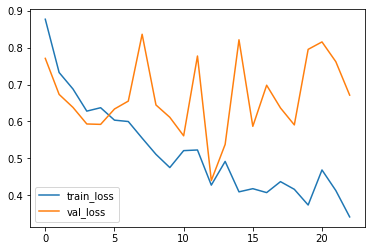

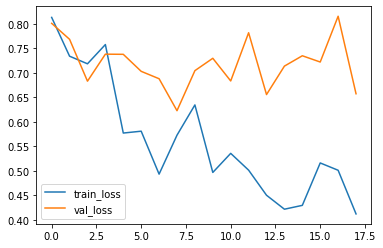

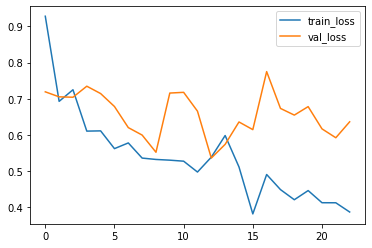

In [ ]:

in_features = X.shape[1]
verbose = True
batch_size = 8
epochs = 30
out_features = 1
index_test = []
feature_vectore = np.zeros([0, 32], dtype=np.float32)

cv = KFold(n_splits=3, shuffle=True, random_state=0)
i=1
for train_ix, test_ix in cv.split(X):
	
	# split data
	X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
	y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

	# get validation set
	X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

	# Normalise data
	X_train,X_val,X_test = normalize(X_train,X_val,X_test)
	#X_test = normalize(X_test)
	#X_val = normalize(X_val)
	print('Train, val, test shape run:', i, X_train.shape, X_val.shape, X_test.shape)
 
	# convert to event + duration
	y_train= get_target(y_train)
	durations_test, events_test = get_target(y_test)
	y_val= get_target(y_val)
	val_g = X_val, y_val

	# Model
	torch.manual_seed(56) 
	net = torch.nn.Sequential(
   	collections.OrderedDict(
      [
         ("x1", torch.nn.Linear(in_features, 512)),
         ("x2", torch.nn.ReLU()),
         ("x3", torch.nn.BatchNorm1d(512)),
         ("x4", torch.nn.Dropout(0.5)),
         ("x5", torch.nn.Linear(512, 32)),
         ("x6", torch.nn.ReLU()),
         ("x7", torch.nn.BatchNorm1d(32)),
         ("x8", torch.nn.Dropout(0.5)),
         ("x9", torch.nn.Linear(32, out_features)),
      ]
   )
)
	# Same output number
	model = CoxCC(net, tt.optim.Adam)
	model.optimizer.set_lr(0.01)
	lrfinder = model.lr_finder(X_train, y_train, batch_size, tolerance=10)
	lrfinder.get_best_lr()

	callbacks = [tt.callbacks.EarlyStopping()]
	
	log = model.fit(X_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val_g, val_batch_size=batch_size)

	_ = log.plot()

	features = {}
	model.net.x7.register_forward_hook(get_features('x7'))
	_ = model.compute_baseline_hazards()
	surv = model.predict_surv_df(X_test)

	#  Feature extraction
	extracted = features['x7'].cpu().numpy()
	feature_vectore = np.append(feature_vectore, extracted, axis=0)

	ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
	print(i, "Transcriptomic C-Index", ev.concordance_td())
	i+=1
	index_test = np.append(index_test, test_ix)
  
 
   



In [ ]:
patient_name=OV_RNa_seq_sur[['EnsemblgeneID']]

In [ ]:
feature_vectore.shape

(424, 32)

In [ ]:
#index_test

In [ ]:
index_test = index_test.astype(int)
names_index = patient_name.values[index_test]

In [ ]:
#names_index

In [ ]:
#bb=np.concatenate((names_index,feature_vectore), axis=1)
#np.savetxt("/content/drive/MyDrive/Feature-vector/Same-S/test.csv", bb, delimiter=",",fmt='%s')

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import shap
import matplotlib.pyplot as plt

In [ ]:
X.head(0)

,C2_8,C2_9,C2_10,C2_15,C2_18,C2_19,C2_23,C2_25,C2_28,C2_57,...,C2_13059,C2_13060,C2_13063,C2_13064,C2_13067,C2_13068,C2_13069,C2_13070,C2_13075,C2_13077


In [ ]:
f12=fe5.to_numpy

In [ ]:
#features=pd.read_csv('/content/2000-gene-name.csv',header=None).T

In [ ]:
#features.to_csv('gene-name.csv')

23:	[0s / 0s],		train_loss: 0.5188


  0%|          | 0/5 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

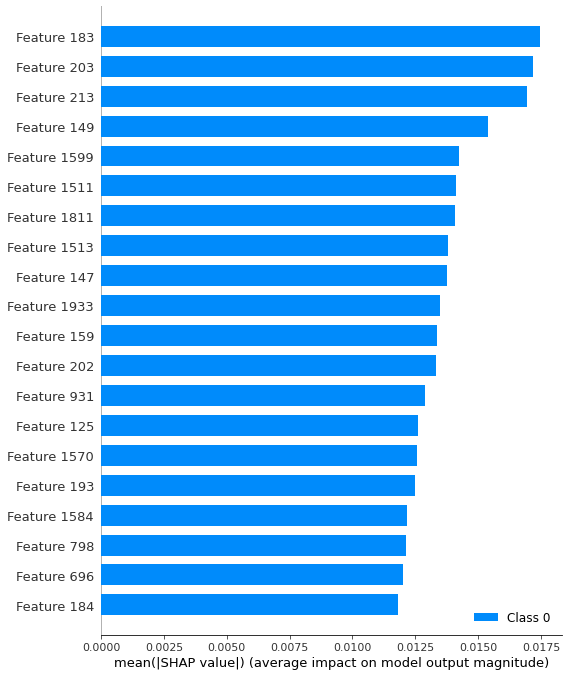

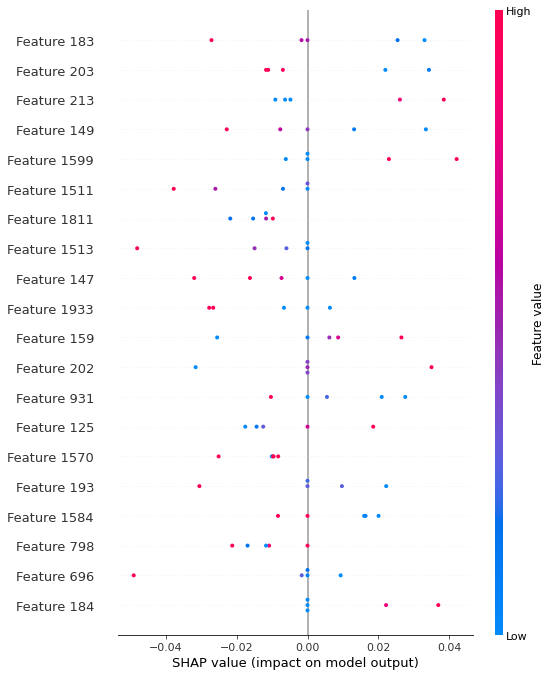

In [ ]:
shap.initjs()
X_train1 = X_train[:5, :]
X_test1 =X_test[:5,:].astype(np.float32)
model.fit(X_train, y_train)

_ = model.compute_baseline_hazards()

explainer = shap.KernelExplainer(model.predict, X_train1)
shaps = explainer.shap_values(X_test1)
shap.summary_plot(shaps, X_test1)
shap.summary_plot(shaps[0], X_test1)

In [ ]:
plt.savefig('mygraph.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.savefig('scratch.pdf')

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.savefig('shap.pdf',transparent=True)

<Figure size 432x288 with 0 Axes>